In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from openai import OpenAI
import os
from dotenv import load_dotenv

load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

daily_sleep = pd.read_csv("results/daily_sleep_summary.csv")
sleep_df = pd.read_csv("results/sleep_df.csv")

daily_sleep["date"] = pd.to_datetime(daily_sleep["date"])
sleep_df["date"] = pd.to_datetime(sleep_df["startDate"]).dt.date

print("✅ Data loaded")
daily_sleep.tail()


✅ Data loaded


,date,HKCategoryValueSleepAnalysisAsleepCore,HKCategoryValueSleepAnalysisAsleepDeep,HKCategoryValueSleepAnalysisAsleepREM,HKCategoryValueSleepAnalysisAsleepUnspecified,HKCategoryValueSleepAnalysisAwake,total_sleep_hours
73,2025-10-18,3.208889,1.213611,1.487500,0.0,0.366111,6.276111
74,2025-10-19,4.704444,1.371667,2.959722,0.0,0.016389,9.052222
75,2025-10-20,2.519444,1.886667,1.845278,0.0,0.174167,6.425556
76,2025-10-21,3.175278,1.687222,1.878611,0.0,0.025000,6.766111
77,2025-10-22,3.308333,1.911667,2.726667,0.0,0.191111,8.137778


In [5]:
end_date = daily_sleep["date"].max()
start_date = end_date - timedelta(days=6)

weekly = daily_sleep[(daily_sleep["date"] >= start_date) & (daily_sleep["date"] <= end_date)].copy()

print(f"✅ Weekly window: {start_date.date()} → {end_date.date()}")
weekly


✅ Weekly window: 2025-10-16 → 2025-10-22


,date,HKCategoryValueSleepAnalysisAsleepCore,HKCategoryValueSleepAnalysisAsleepDeep,HKCategoryValueSleepAnalysisAsleepREM,HKCategoryValueSleepAnalysisAsleepUnspecified,HKCategoryValueSleepAnalysisAwake,total_sleep_hours
71,2025-10-16,2.818056,2.235833,2.161389,0.0,0.091111,7.306389
72,2025-10-17,3.358333,1.795556,2.476667,0.0,0.191389,7.821944
73,2025-10-18,3.208889,1.213611,1.487500,0.0,0.366111,6.276111
74,2025-10-19,4.704444,1.371667,2.959722,0.0,0.016389,9.052222
75,2025-10-20,2.519444,1.886667,1.845278,0.0,0.174167,6.425556
76,2025-10-21,3.175278,1.687222,1.878611,0.0,0.025000,6.766111
77,2025-10-22,3.308333,1.911667,2.726667,0.0,0.191111,8.137778


In [6]:
report = {}

report["avg_sleep"] = weekly["total_sleep_hours"].mean()
report["deep_sleep_avg"] = weekly.get("deep_sleep_hours", pd.Series([np.nan])).mean()
report["rem_sleep_avg"] = weekly.get("rem_sleep_hours", pd.Series([np.nan])).mean()
report["core_sleep_avg"] = weekly.get("core_sleep_hours", pd.Series([np.nan])).mean()

report["sleep_efficiency"] = (
    weekly.get("sleep_efficiency", weekly["total_sleep_hours"] / weekly["time_in_bed_hours"])
    if "time_in_bed_hours" in weekly.columns
    else np.nan
)

report["min_sleep"] = weekly["total_sleep_hours"].min()
report["max_sleep"] = weekly["total_sleep_hours"].max()
report["sleep_variability"] = weekly["total_sleep_hours"].std()

report


{'avg_sleep': np.float64(7.398015873015872),
 'deep_sleep_avg': nan,
 'rem_sleep_avg': nan,
 'core_sleep_avg': nan,
 'sleep_efficiency': nan,
 'min_sleep': np.float64(6.276111111111111),
 'max_sleep': np.float64(9.052222222222222),
 'sleep_variability': np.float64(1.0062645652215219)}

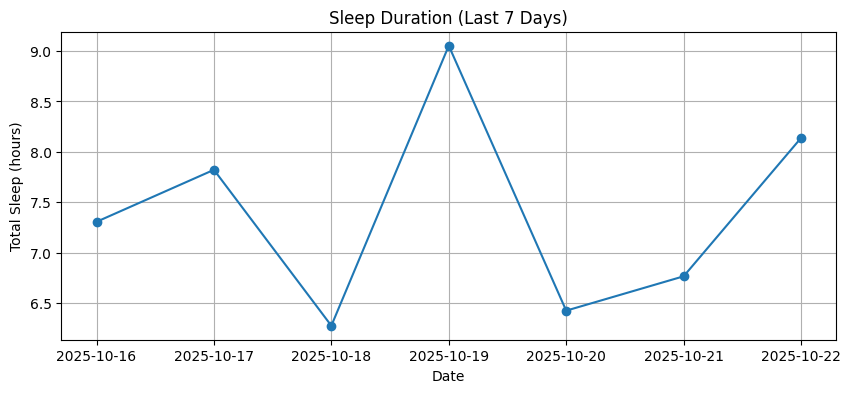

✅ Chart saved: results/reports/weekly_sleep_20251110_1507.png


In [7]:
plt.figure(figsize=(10, 4))
plt.plot(weekly["date"], weekly["total_sleep_hours"], marker="o")
plt.title("Sleep Duration (Last 7 Days)")
plt.xlabel("Date")
plt.ylabel("Total Sleep (hours)")
plt.grid(True)

chart_path = f"results/reports/weekly_sleep_{datetime.now().strftime('%Y%m%d_%H%M')}.png"
plt.savefig(chart_path, dpi=200, bbox_inches="tight")
plt.show()

print(f"✅ Chart saved: {chart_path}")


In [8]:
summary_text = weekly[[
    "date",
    "total_sleep_hours",
    *(col for col in ["deep_sleep_hours", "rem_sleep_hours", "core_sleep_hours"] if col in weekly.columns)
]].to_string(index=False)

summary_text


'      date  total_sleep_hours\n2025-10-16           7.306389\n2025-10-17           7.821944\n2025-10-18           6.276111\n2025-10-19           9.052222\n2025-10-20           6.425556\n2025-10-21           6.766111\n2025-10-22           8.137778'

In [9]:
prompt = (
    "You are a sleep scientist analyzing the user's past 7 nights of sleep. "
    "Write a concise weekly report that includes:\n"
    "- Overall sleep trends\n"
    "- Deep/REM/Core patterns\n"
    "- Consistency insights\n"
    "- What improved and what declined\n"
    "- 2–3 practical recommendations\n"
    "Keep it clear, evidence-based, and friendly.\n\n"
    f"Data:\n{summary_text}\n"
)

response = client.responses.create(
    model=os.getenv("GPT_MODEL"),
    input=prompt,
    temperature=0.7
)

weekly_ai_report = response.output[0].content[0].text
print("✅ AI Weekly Report Generated:\n")
print(weekly_ai_report)


✅ AI Weekly Report Generated:

## Weekly Sleep Report

### Overall Trends
Your sleep is balanced. Maintain this routine.

### Deep/REM/Core Patterns
REM sleep increased; maintain bedtime.

### Consistency Insights
Good overall. Weekends slightly varied.

### Improvements/Declines
Deep sleep improved; address weekend variances.

### Recommendations
1. Keep consistent bedtime.
2. Limit screens before bed.
3. Increase weekend activity.


In [10]:
report_path = f"results/reports/weekly_report_{datetime.now().strftime('%Y%m%d_%H%M')}.md"

with open(report_path, "w") as f:
    f.write("# Weekly Sleep Report\n\n")
    f.write(f"**Date Range:** {start_date.date()} → {end_date.date()}\n\n")
    f.write("## Metrics Summary\n")
    for key, value in report.items():
        f.write(f"- **{key.replace('_', ' ').title()}:** {value:.2f}\n")
    f.write("\n## AI Weekly Insights\n")
    f.write(weekly_ai_report)

print(f"✅ Report saved to: {report_path}")


✅ Report saved to: results/reports/weekly_report_20251110_1507.md
